In [1]:
from datetime import datetime  
from functools import partial
import numpy as np
import tensorflow as tf
import importlib
from tensorflow.keras import regularizers
from tensorflow.python.ops.numpy_ops import np_config
import io_functions as io
import plotting_functions as plf
from pathlib import Path
np_config.enable_numpy_behavior()

2024-01-01 07:16:26.501078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation

### Description
The data used for training the model was generated in numerical simulations in the .root format. It was then converted to the .tfrecord format using the `ROOT_to_TFRecord.ipynb` notebook and the `conversion_xyz` function.

This notebook presents the xyz reconstruction approach, where the model takes all three projections in uvwt coordinates and performs reconstruction to obtain the xyz coordinates of an event.

In [2]:
dataPath = "/scratch/pszyc"
batchSize = 32

2024-01-01 07:16:32.883334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


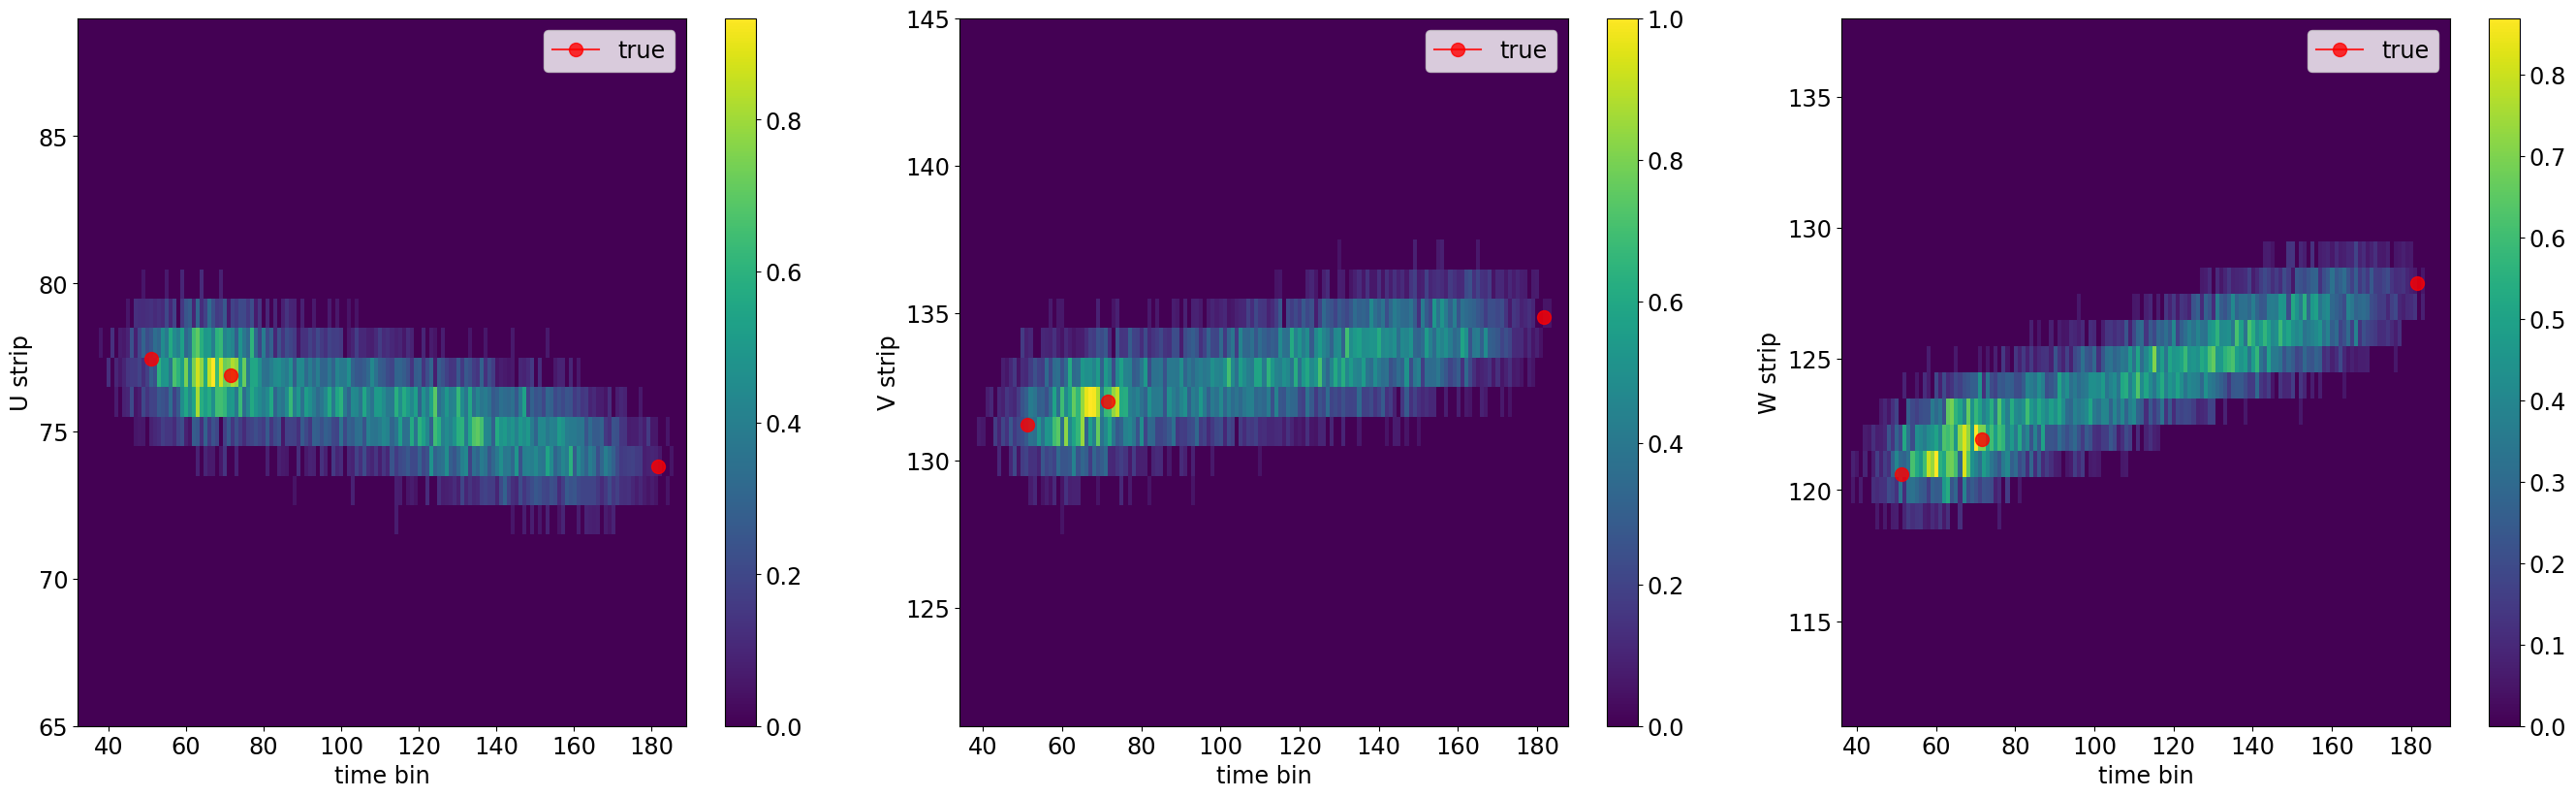

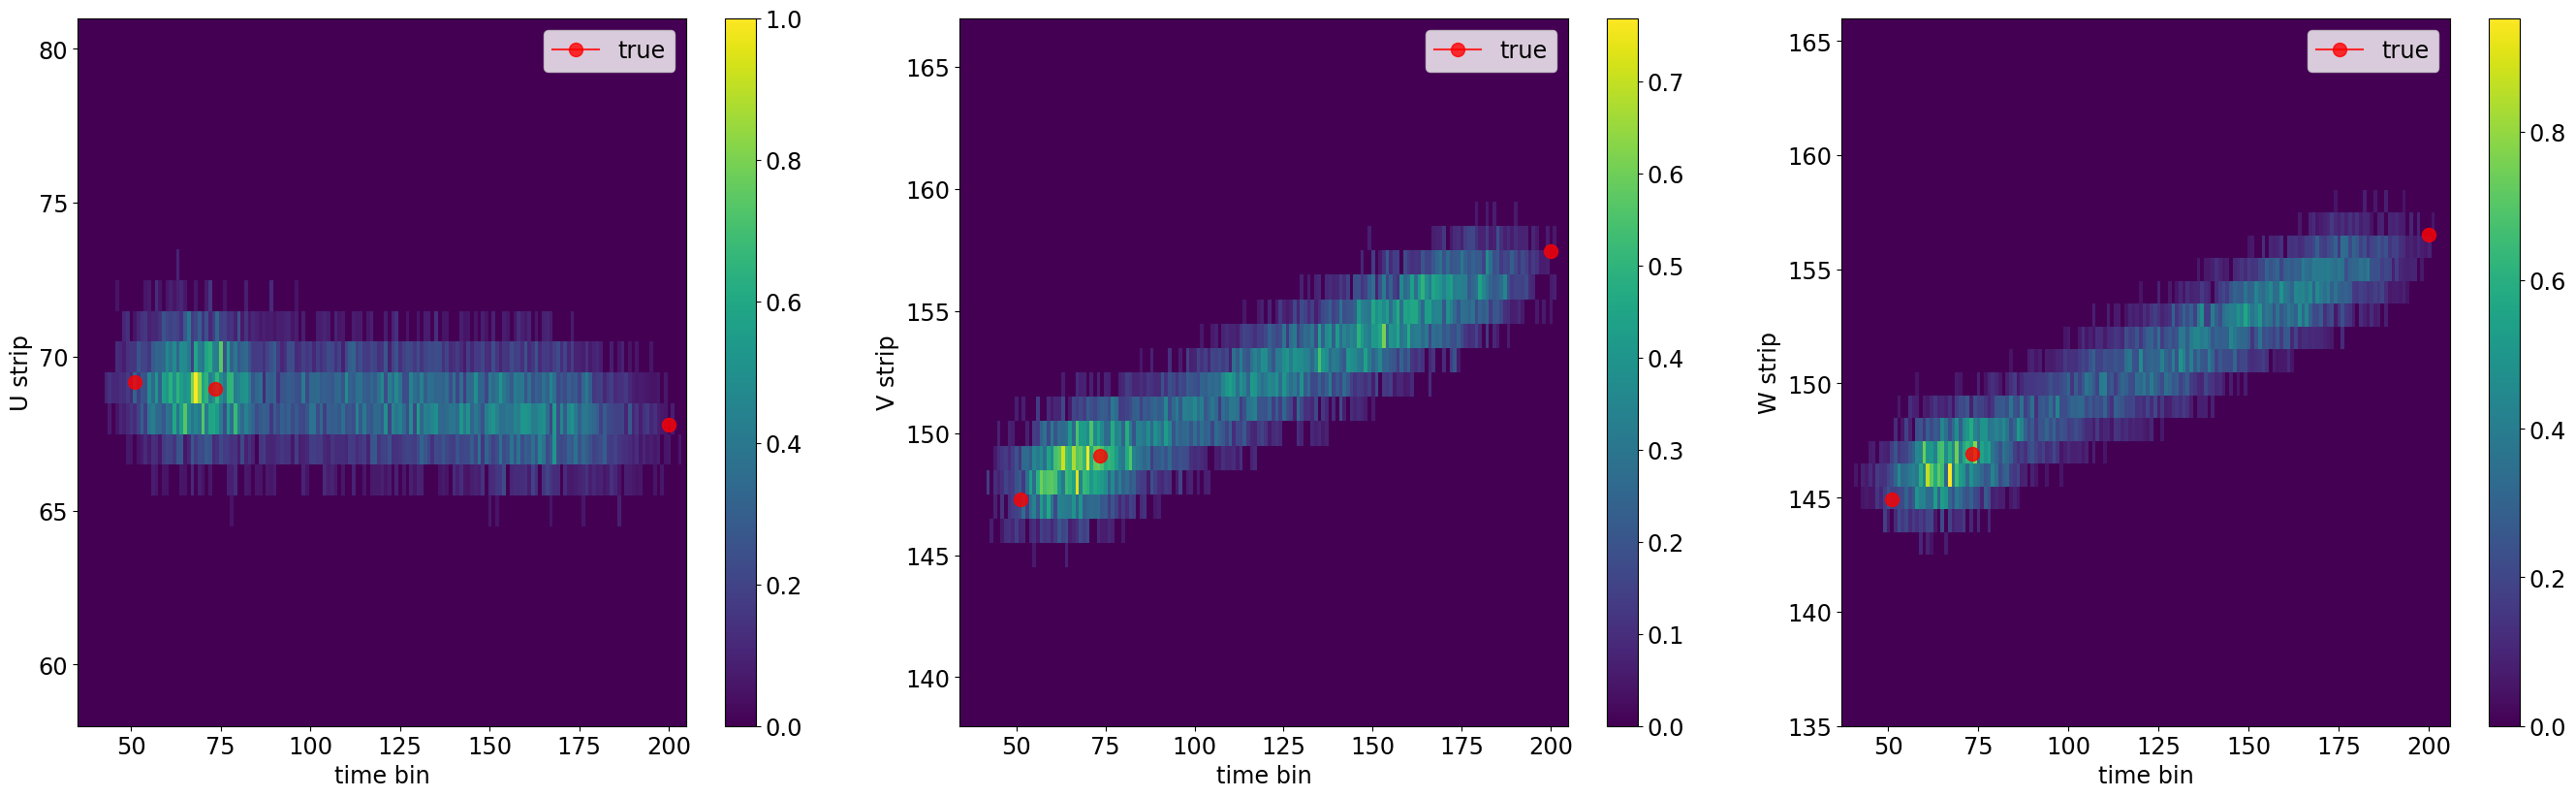

In [3]:
filenames = [f"{dataPath}/data_xyz/out_random_sigma-001-part-{i}.tfrecord" for i in range(5)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(f"{dataPath}/data_xyz/out_random_sigma2k2mm-part-0.tfrecord", compression_type='GZIP')
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)
    
    return charge, target

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.batch(batchSize)
test_dataset = test_dataset.batch(batchSize)

for aBatch in train_dataset.take(1):
    plf.plotEvent(aBatch, model=None)

for aBatch in test_dataset.take(1):
    plf.plotEvent(aBatch, model=None)

# Training

In [21]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape = (256, 512, 3)),
  #tf.keras.layers.Resizing(height=128, width=128), 
  #tf.keras.layers.GaussianNoise(stddev=0.1),
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=5000,
                decay_rate=0.98,
                staircase=False)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule) 
model.compile(optimizer = optimizer, 
              loss = 'mse', 
              metrics=['mse'])

In [22]:
log_dir = Path(dataPath) / "logs" / 'uwvt' / f"model-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    profile_batch=(10, 20)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    mode = 'min',
    patience=4,
    restore_best_weights=True
)

2023-12-29 07:02:00.052327: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-29 07:02:00.052426: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-29 07:02:00.053455: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [23]:
epochs=5
history = model.fit(train_dataset, 
                    epochs=epochs,
                    workers = 3,
                    use_multiprocessing = True,
                    validation_data = test_dataset.take(10),
                    callbacks = [early_stopping, tensorboard_callback]
                    )

Epoch 1/5
      9/Unknown - 76s 8s/step - loss: 0.2025 - mse: 0.2025

2023-12-29 07:03:17.012855: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-29 07:03:17.012926: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


     20/Unknown - 165s 8s/step - loss: 0.1667 - mse: 0.1667

2023-12-29 07:04:46.165336: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-12-29 07:04:46.189642: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-29 07:04:46.190730: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: /scratch/pszyc/logs/uwvt/model-20231229-070200/plugins/profile/2023_12_29_07_04_46/zcobl3.xplane.pb


     28/Unknown - 230s 8s/step - loss: 0.1412 - mse: 0.1412

KeyboardInterrupt: 

In [ ]:
current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")

job_dir = f"{dataPath}/{epochs:04d}_"+current_time
model.save(job_dir.format(epochs=epochs), save_format='tf')

# Validation

Fill Pandas DataFrame with true and response values.

Inference. Current Time = 2024_Jan_01_07_16_56


,GEN_StartPosX,GEN_StartPosY,GEN_StartPosZ,GEN_StopPosX_Part1,GEN_StopPosY_Part1,GEN_StopPosZ_Part1,GEN_StopPosX_Part2,GEN_StopPosY_Part2,GEN_StopPosZ_Part2,RECO_StartPosX,RECO_StartPosY,RECO_StartPosZ,RECO_StopPosX_Part1,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,2.002674,0.114442,-37.271160,-0.268222,-1.153749,-40.096214,1.646887,0.184261,-36.913868,0.871404,-0.377078,-35.777210,0.794061,0.919219,-41.055378,0.424119,-0.884695,-35.270473
std,58.227592,9.839752,18.927197,69.877075,38.589870,21.160934,58.246956,10.390595,22.339684,57.364841,8.591722,17.887114,64.857040,34.955612,16.772755,57.457161,8.034168,20.764381
min,-99.457291,-19.518866,-52.940796,-193.705170,-158.999878,-71.193680,-104.733360,-25.068010,-52.946159,-99.652664,-18.886545,-52.855419,-189.756897,-117.281769,-74.481697,-101.429047,-22.434906,-55.143517
25%,-45.789948,-8.115455,-49.782677,-52.482712,-18.046667,-52.946159,-46.413509,-7.291102,-52.946159,-49.746941,-7.384905,-47.936840,-45.404156,-13.367909,-51.077072,-49.852367,-7.180114,-50.034325
50%,3.064405,0.588820,-46.339069,0.329507,-0.246176,-52.946159,0.722082,0.759049,-48.078506,1.520207,-0.006891,-42.524574,0.708836,2.218792,-46.787159,1.072492,-0.494926,-43.982464
75%,53.699883,8.268962,-29.893826,52.097557,19.210268,-31.731750,53.667927,7.702751,-26.803665,52.729408,6.644912,-29.180183,47.008835,18.803478,-38.454552,52.584179,5.420591,-25.815756
max,99.737259,19.400908,52.484314,196.732803,127.186546,59.652695,104.247391,24.799406,61.683956,106.325760,17.315578,52.502094,182.961807,110.328781,42.331089,103.091347,17.267149,62.087845


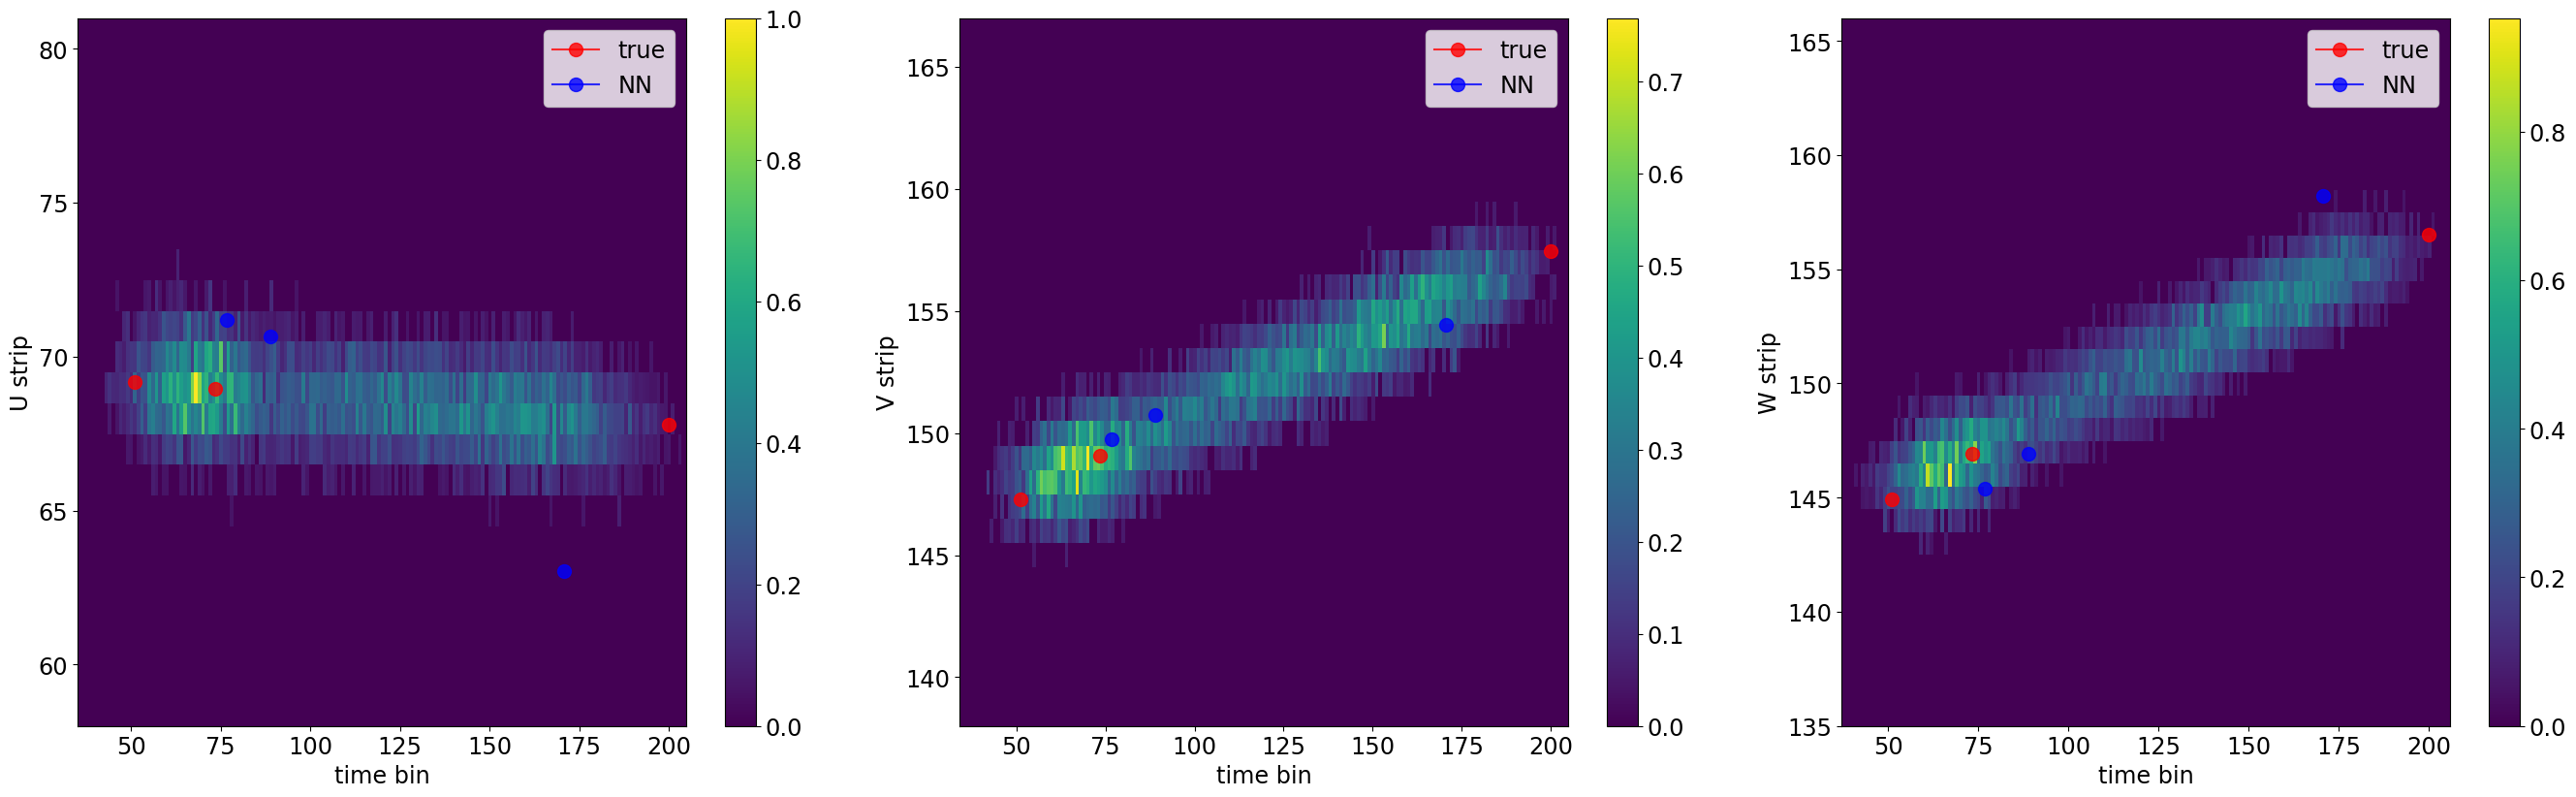

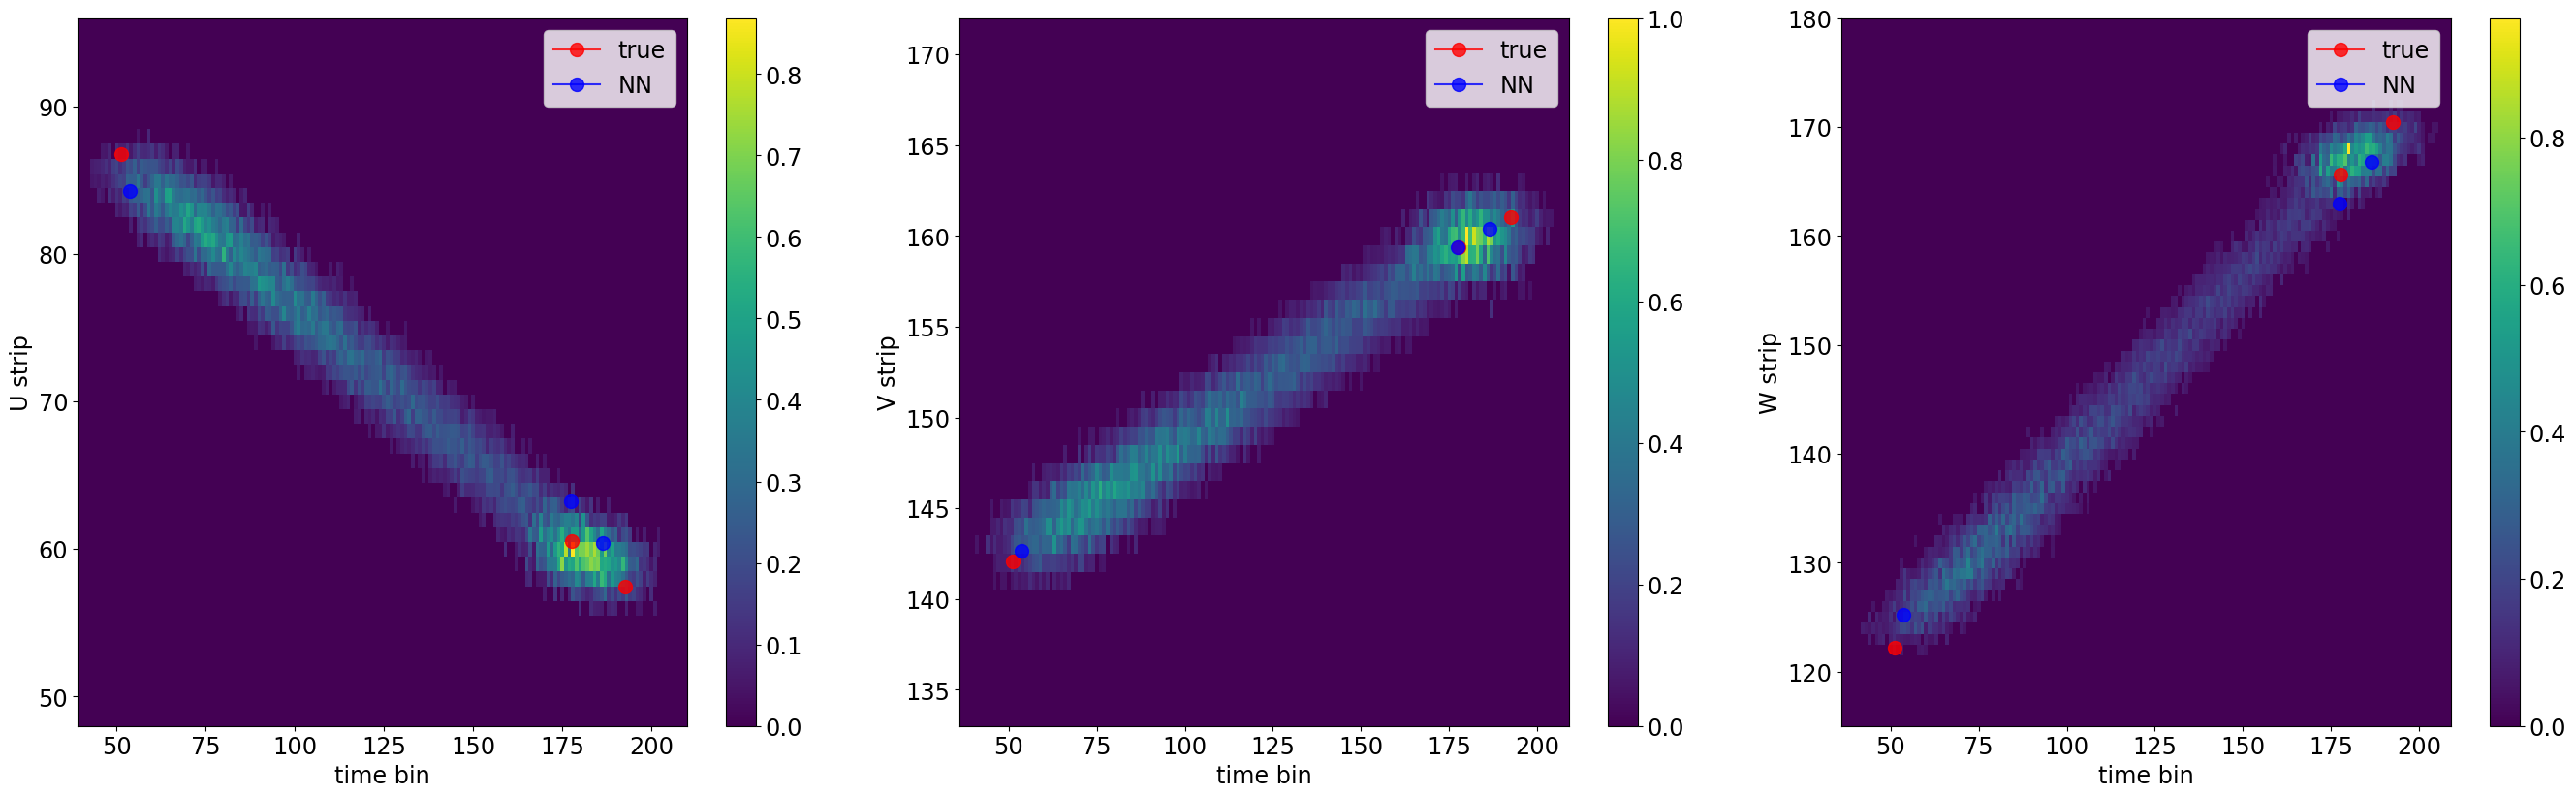

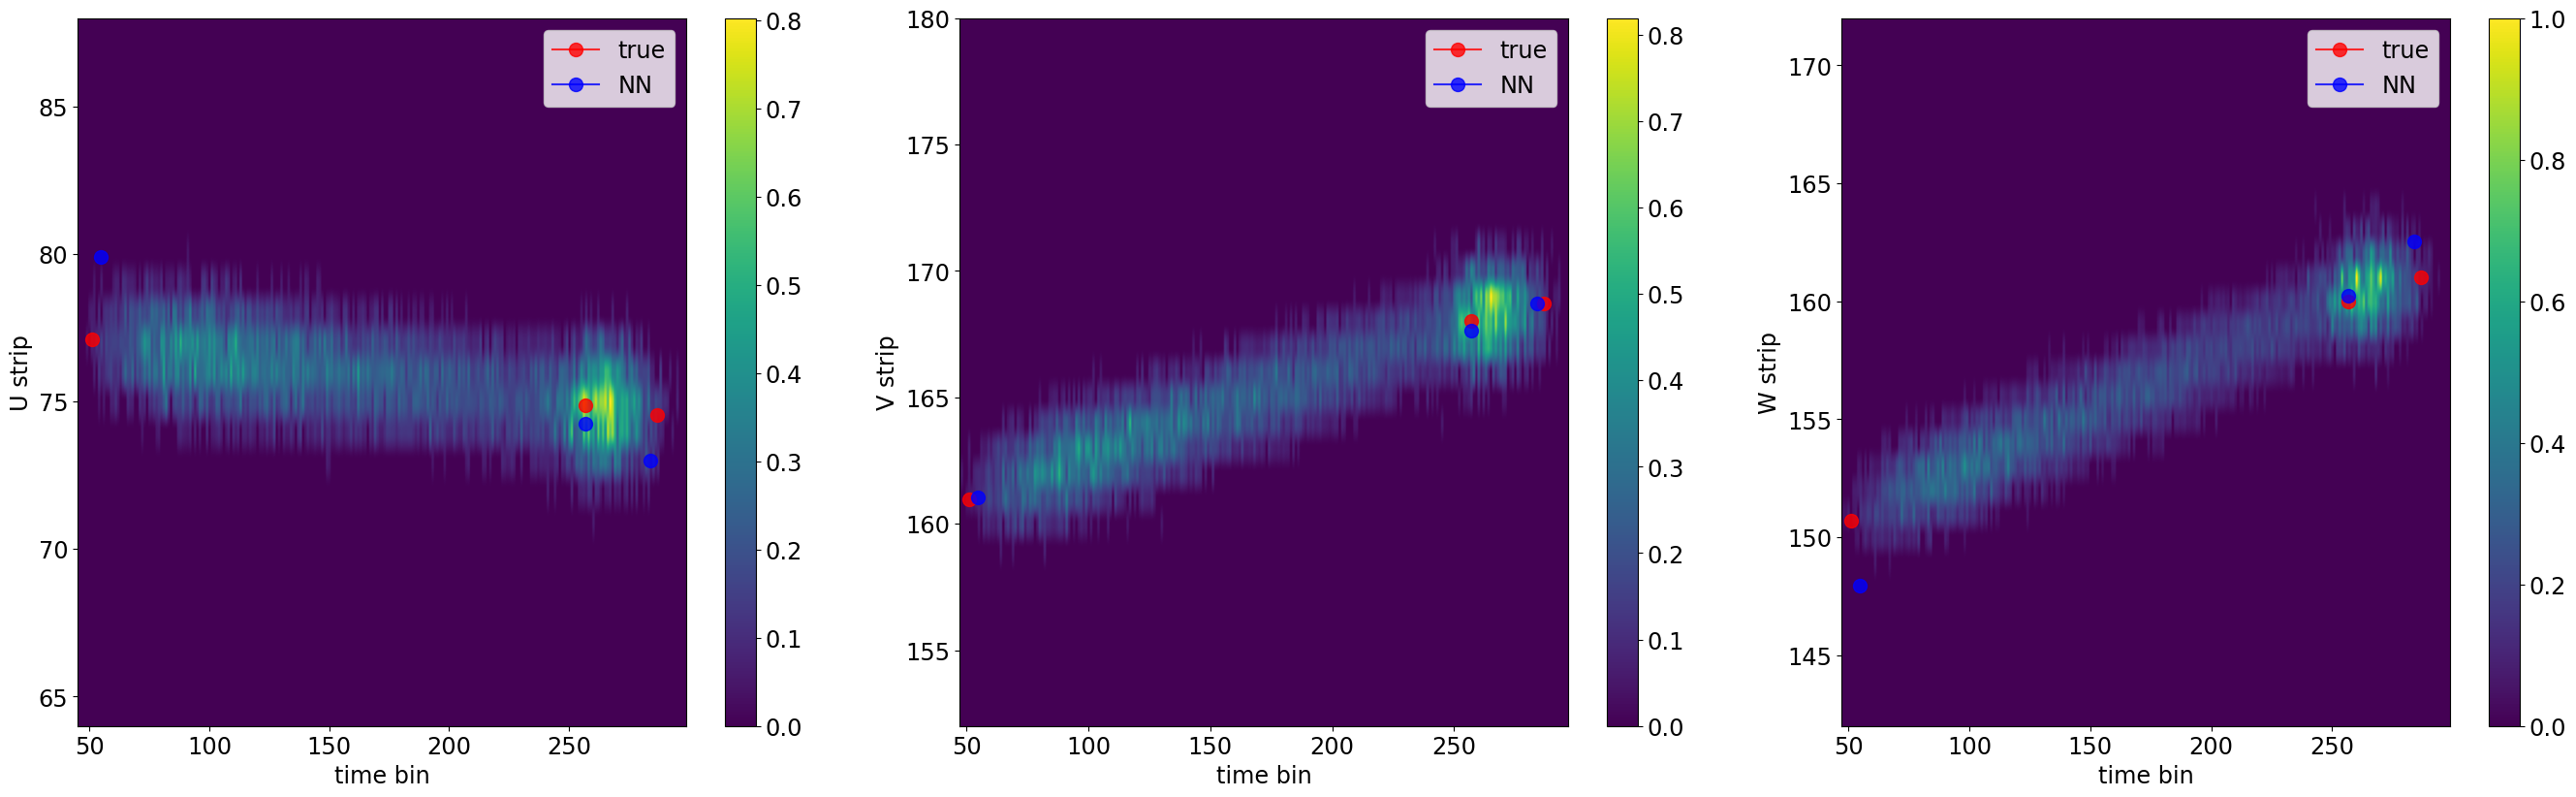

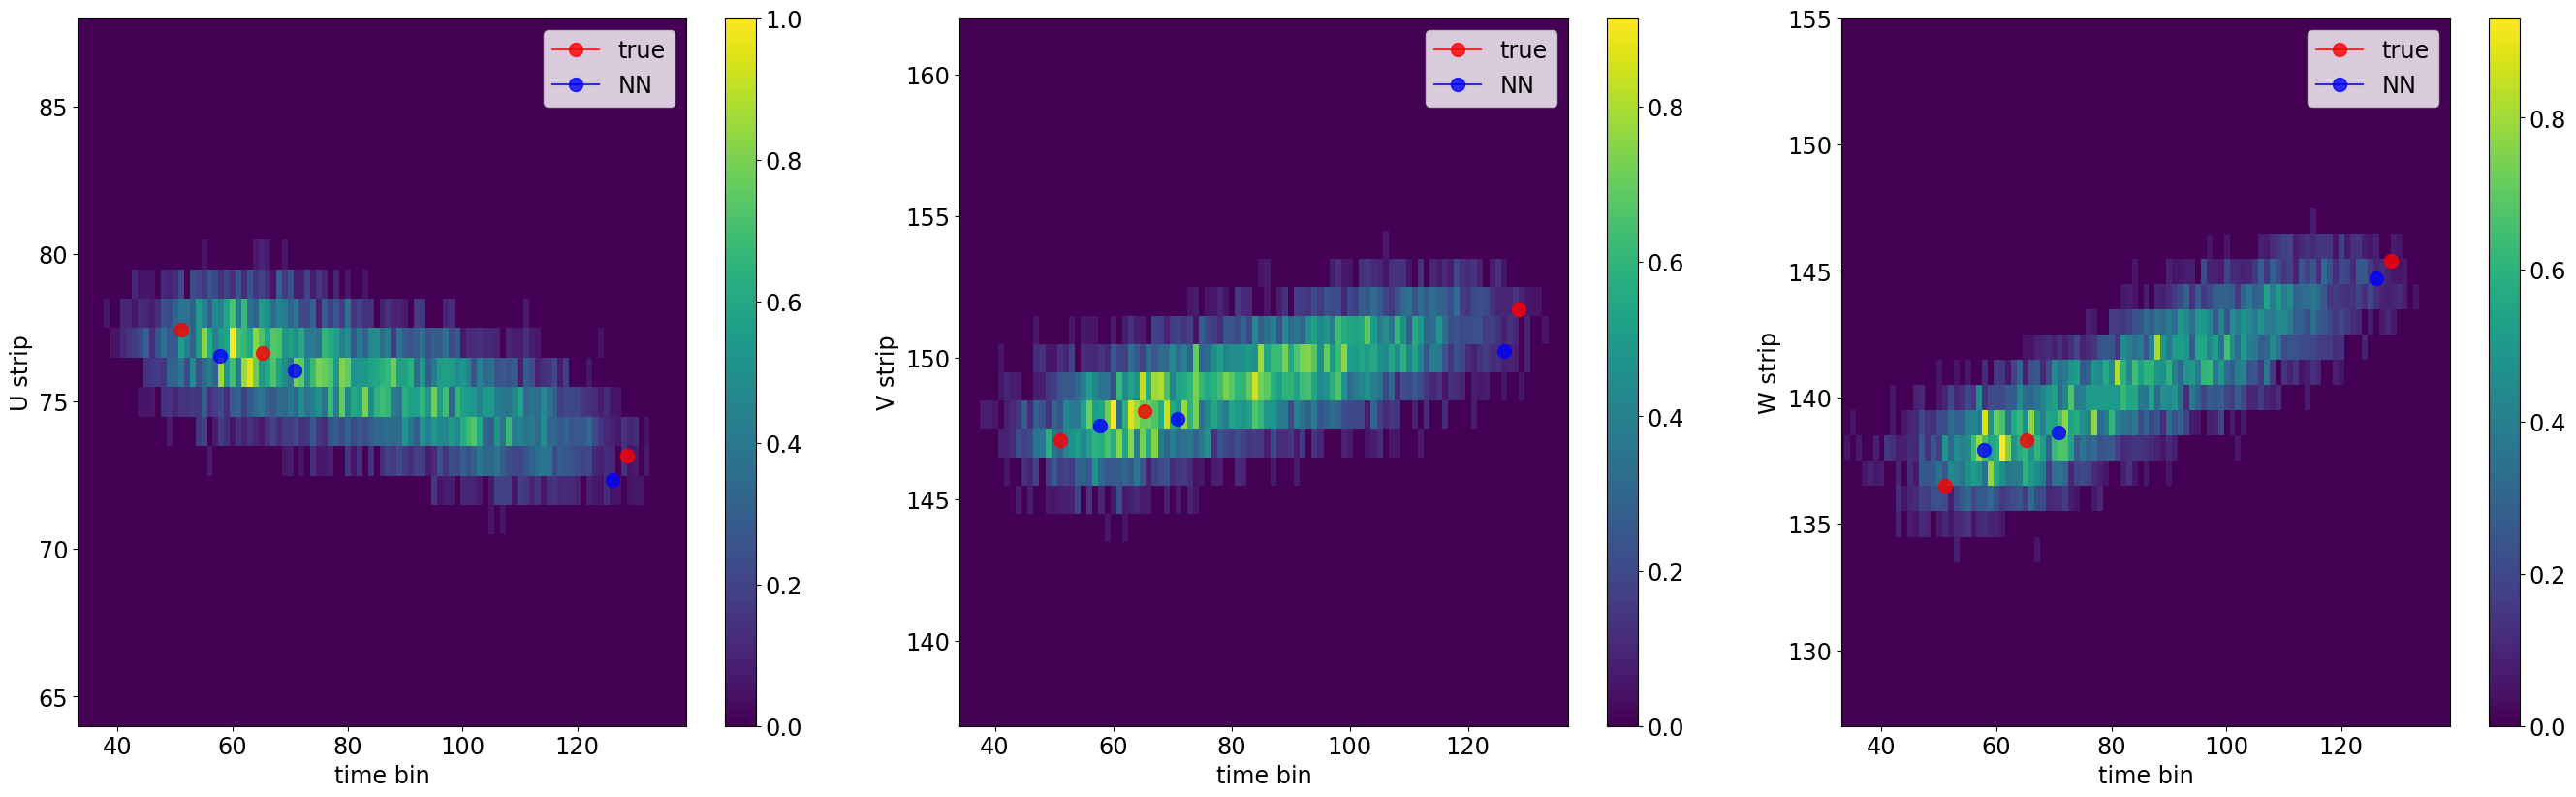

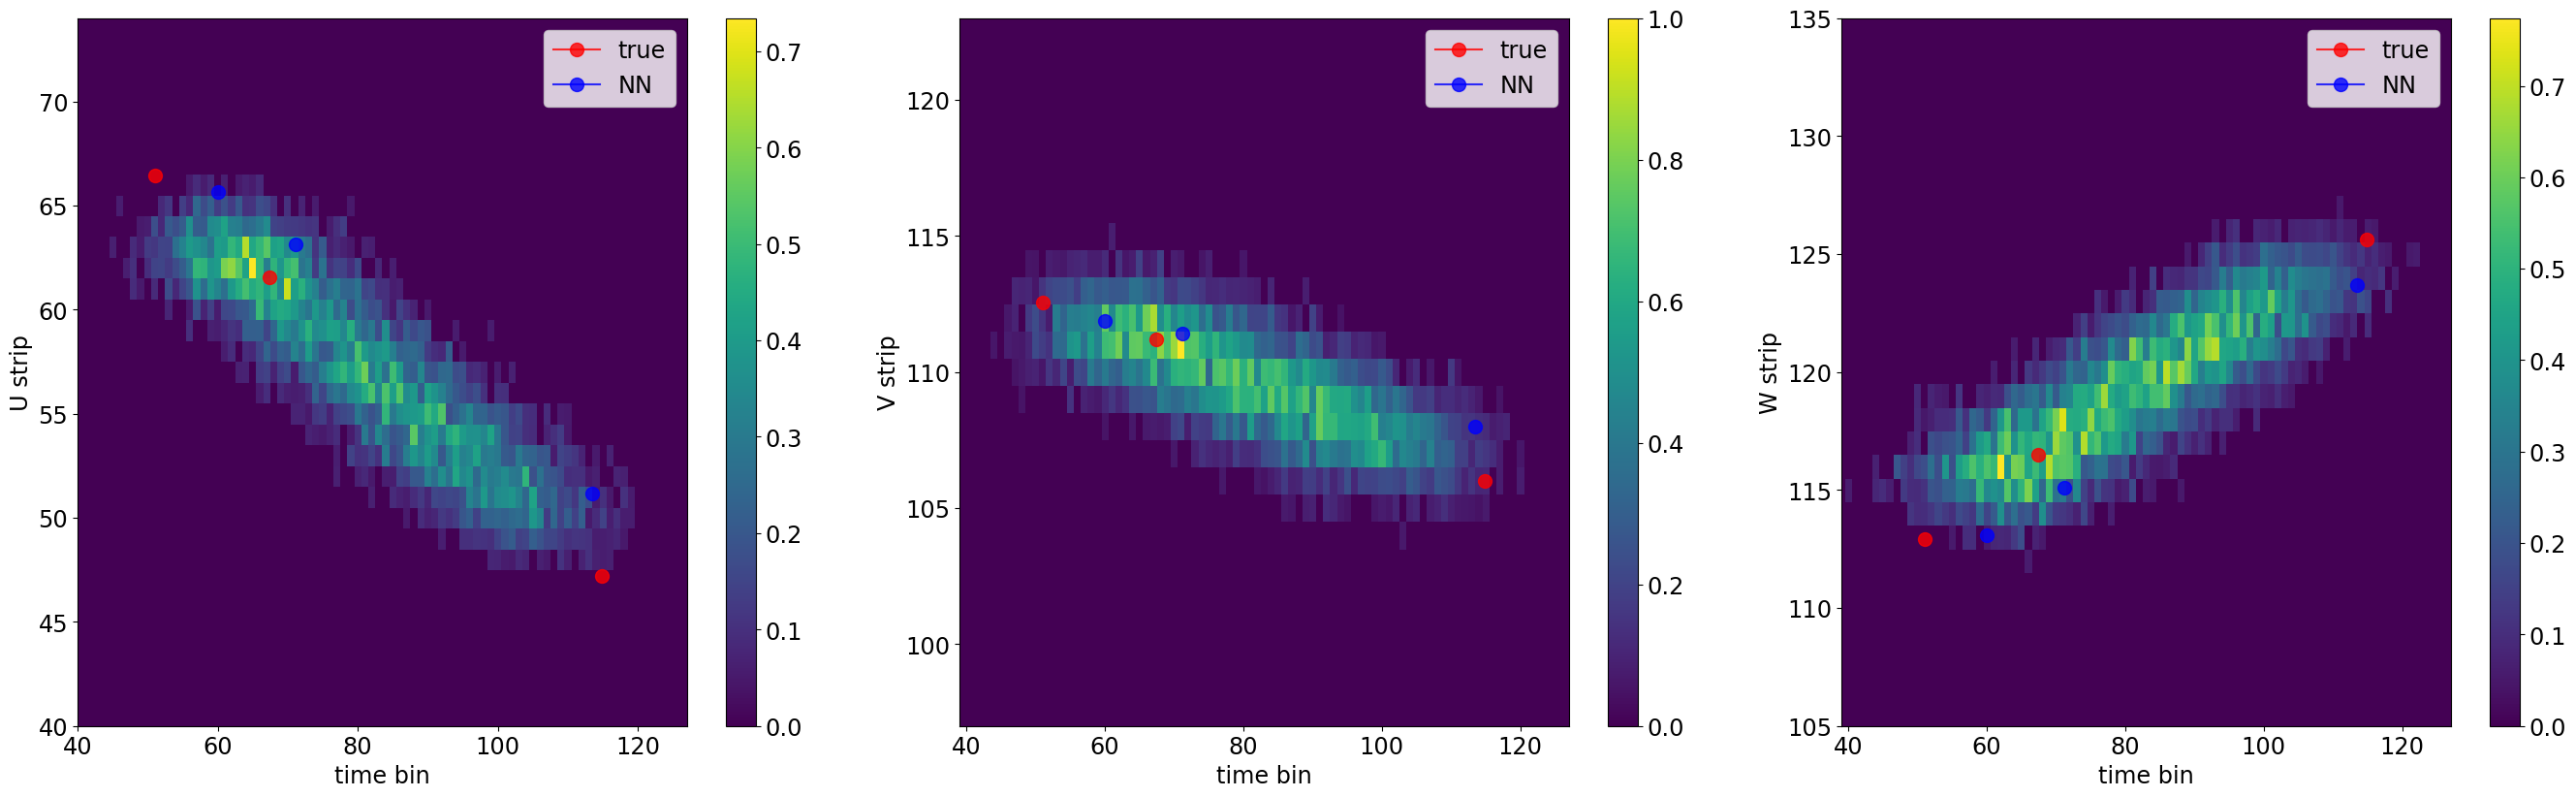

In [4]:
import utility_functions as utils
importlib.reload(utils)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Inference. Current Time =", current_time)

model = tf.keras.models.load_model(f"{dataPath}/0005_2023_Dec_30_11_14_42")

df = utils.df

for aBatch in test_dataset: 
    df = utils.fillPandasDataset(aBatch, df, model)     
    
for aBatch in test_dataset.take(5):
    plf.plotEvent(aBatch, model=model)

df.describe()    

### Resolution plots

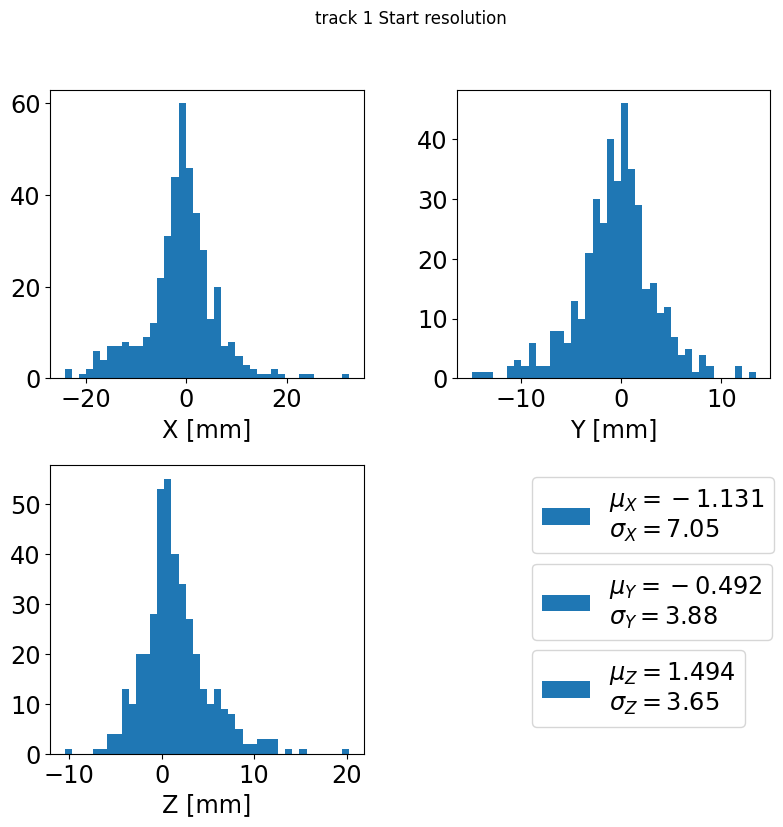

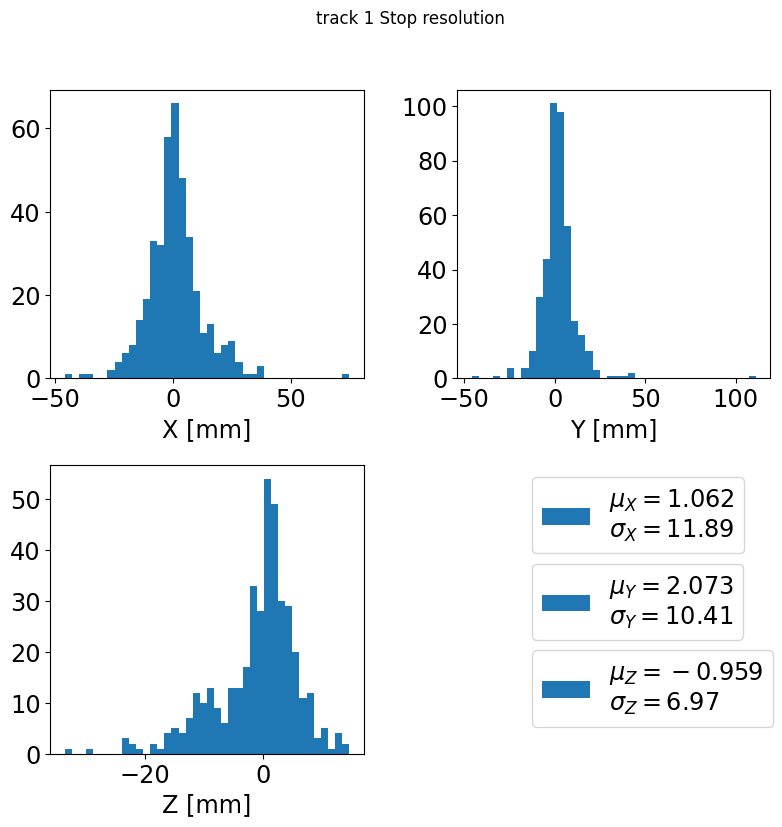

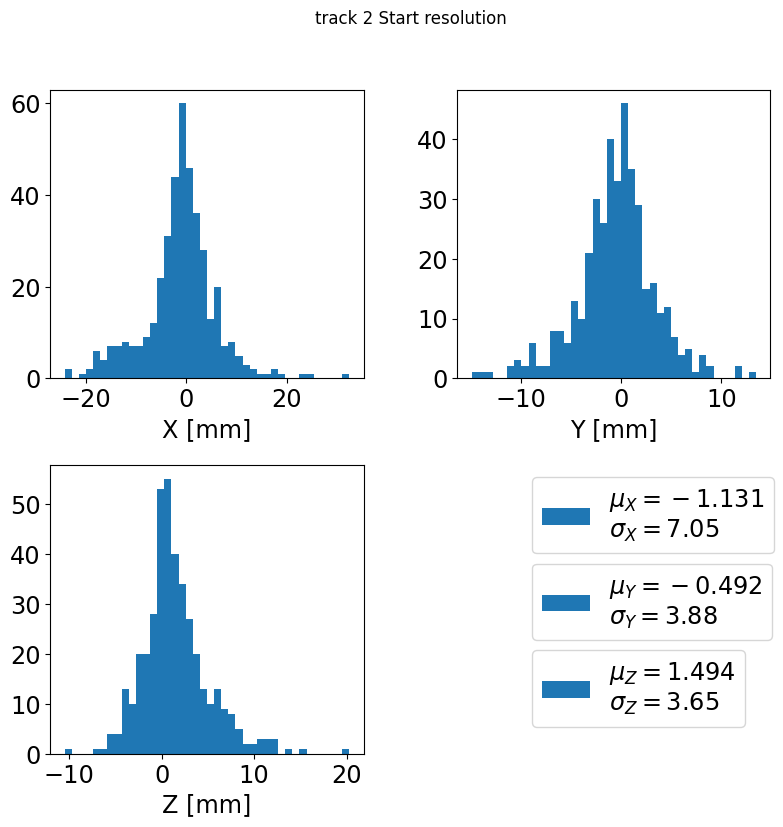

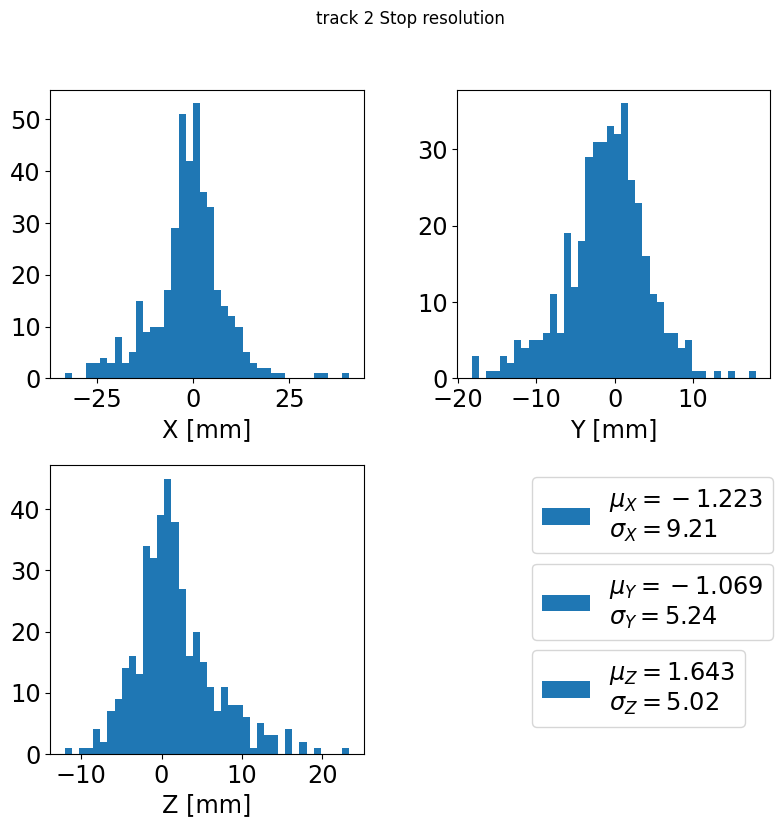

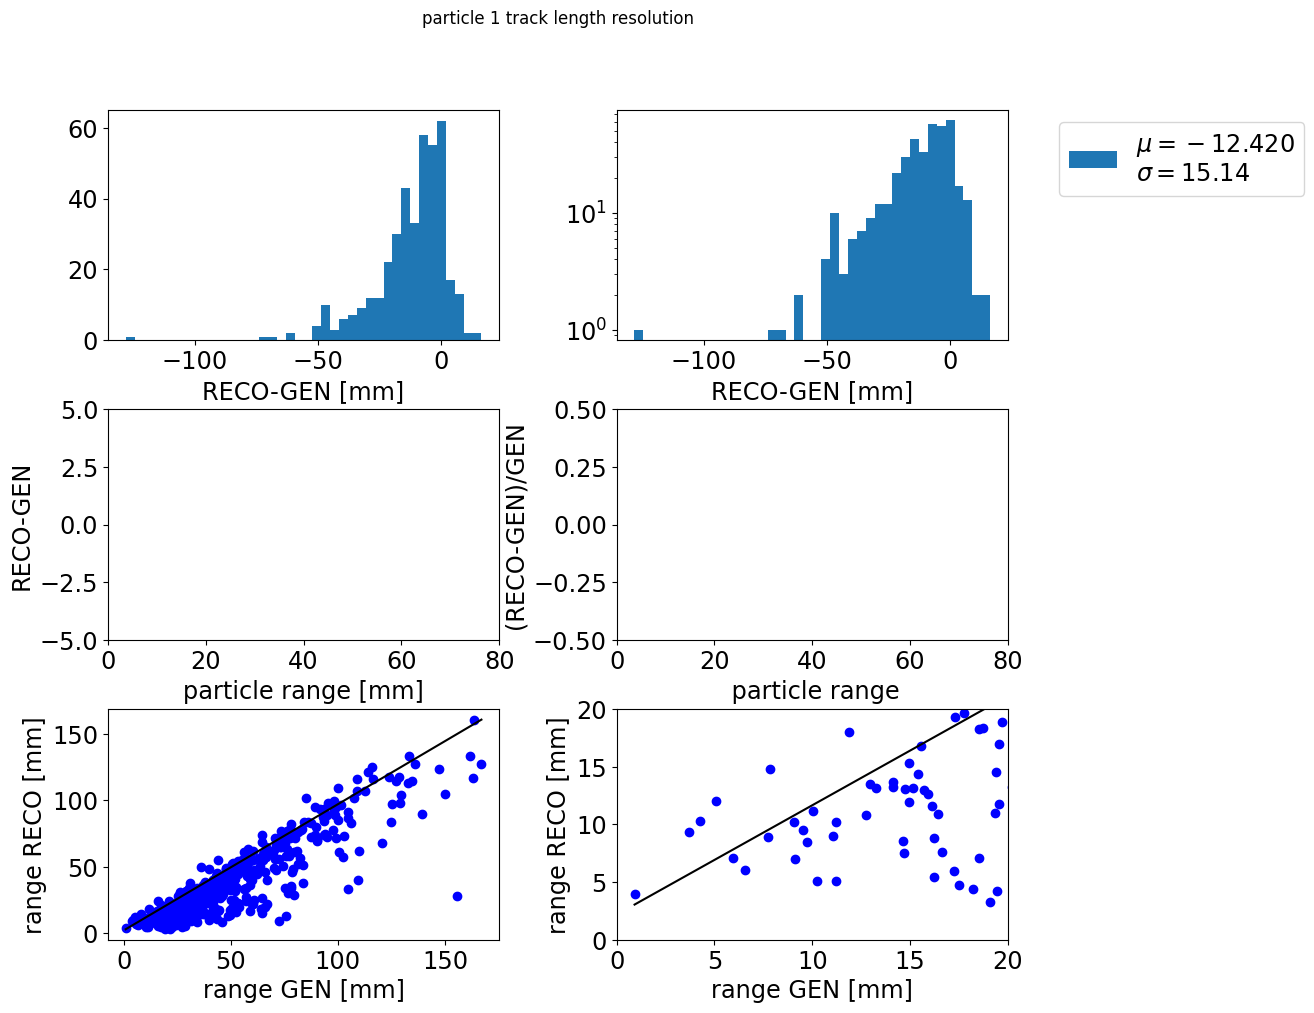

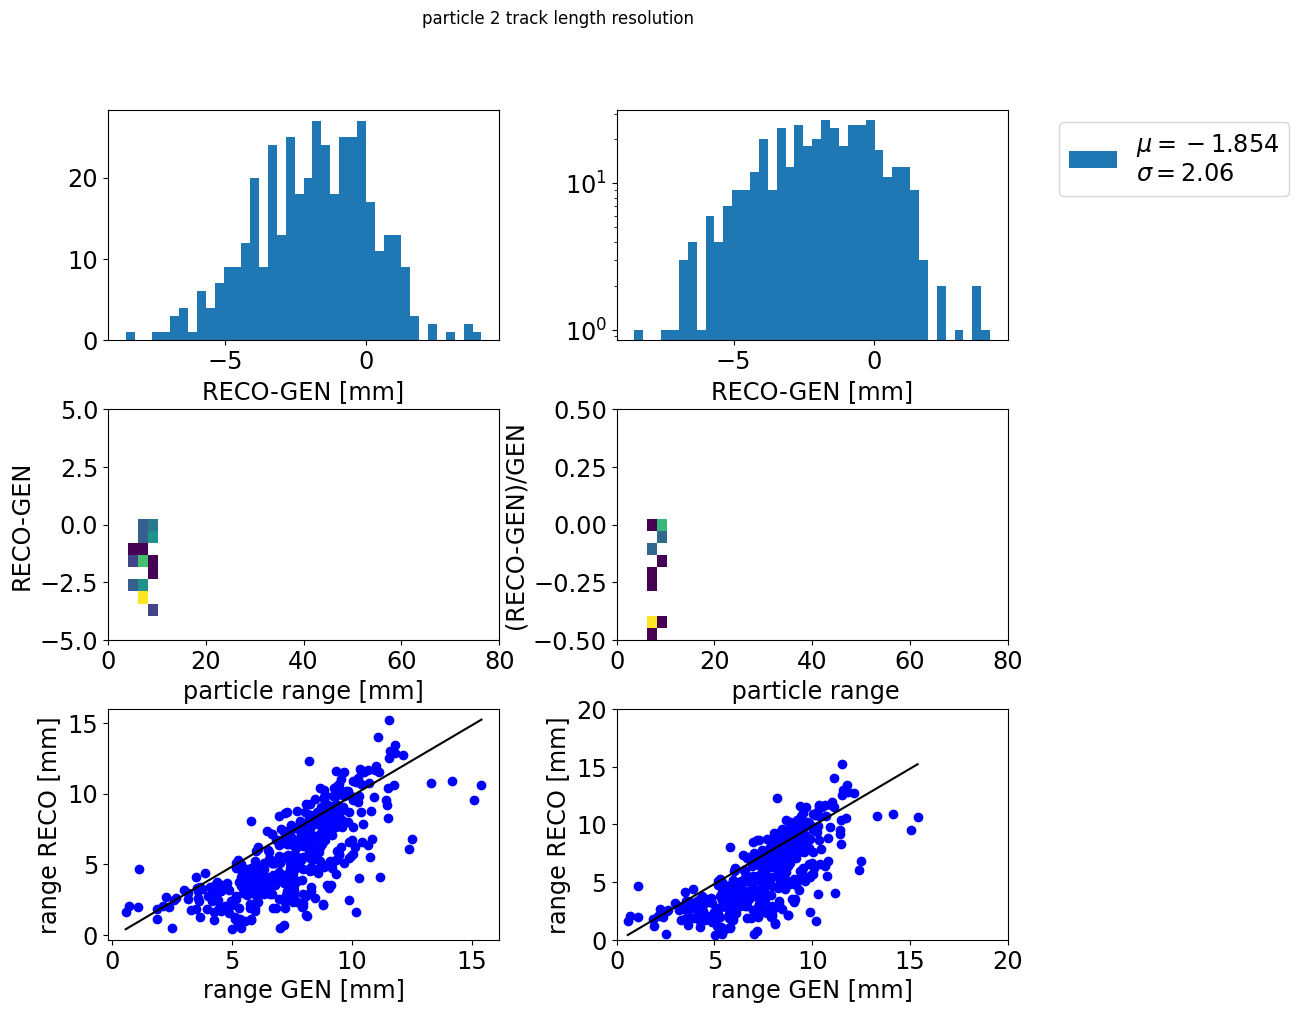

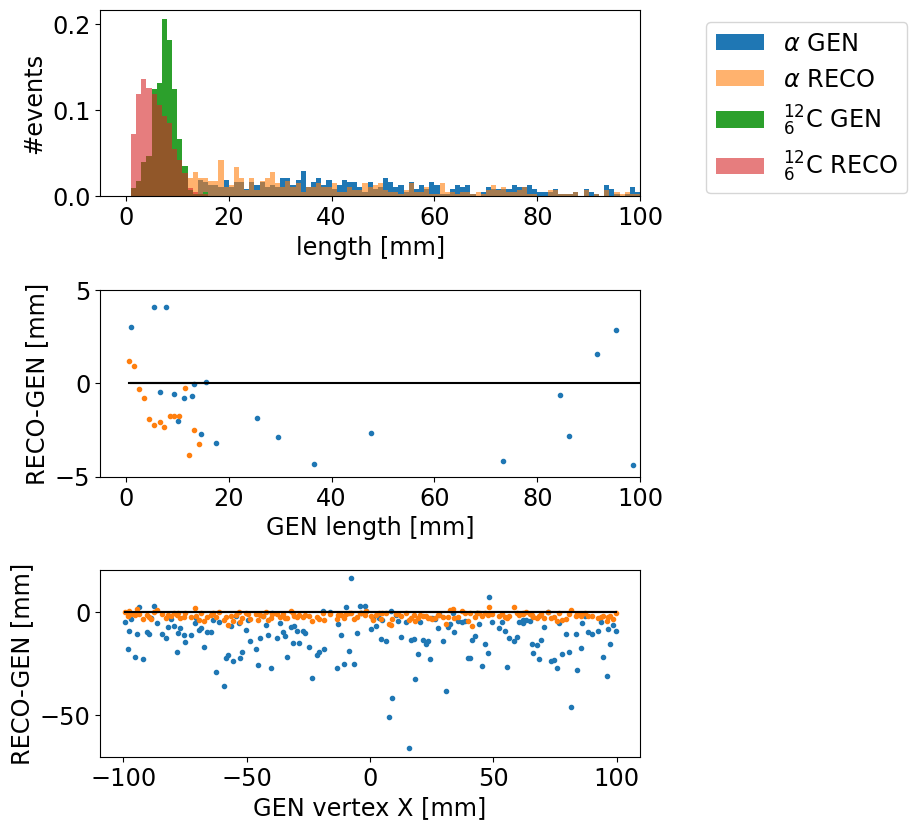

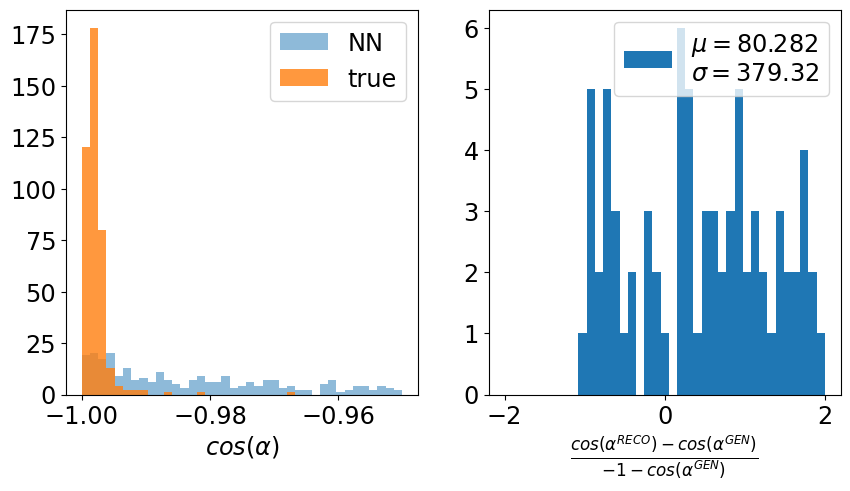

In [5]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotLengthPullEvolution(df)
plf.plotOpeningAngleCos(df)